In [15]:
# Make a gif of the plots in thedirectory
# /projectnb/eb-general/wade/sfno/inference/viz/figures/Experiment1/
import os
import imageio
import matplotlib.pyplot as plt

# Directory containing the images
image_dir = "/projectnb/eb-general/wade/sfno/inference/viz/figures/Experiment1/"
# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
# Sort the image files 
image_files.sort()
# Create a list to hold the images
images = []
# Read each image and append it to the list
for filename in image_files:
    image_path = os.path.join(image_dir, filename)
    images.append(imageio.imread(image_path))

# Save the images as a GIF
gif_path = os.path.join(image_dir, "experiment1_.gif")
imageio.mimsave(gif_path, images, duration=100)  # duration is the time between frames in seconds
print(f"GIF saved at: {gif_path}")


GIF saved at: /projectnb/eb-general/wade/sfno/inference/viz/figures/Experiment1/experiment1_.gif


/scratch/401934.1.ood/ipykernel_770926/785353439.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


Found 1 result files. Combining...


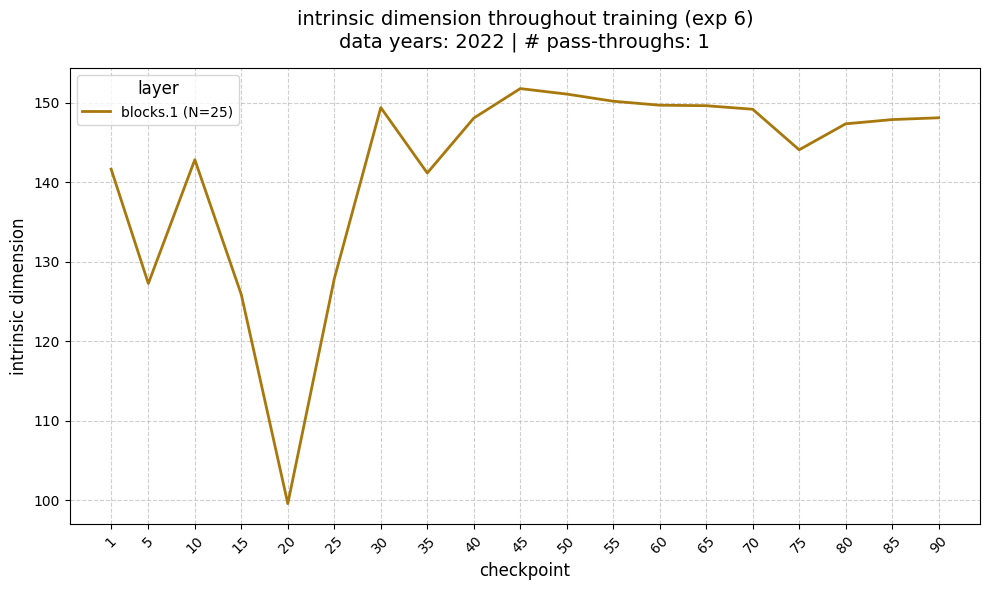

✅ Plot successfully saved to:
/projectnb/eb-general/wade/sfno/inference/viz/figures/Experiment6/ckpt_vs_id_exp6.png


In [10]:
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
# add parent directory to path
os.sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from cmocean import cm as cmo  # for color maps

def plot_id_trajectory(experiment_number, 
                       logs_base_dir="/projectnb/eb-general/wade/sfno/inference/logs/",
                       configs_dir="../configs/",
                       save_base_dir="/projectnb/eb-general/wade/sfno/inference/viz/figures/",
                       cmap=cmo.phase):
    """
    Reads all ID result CSVs for a given experiment, extracts metadata from the config,
    and plots the Intrinsic Dimension over the training epochs.
    """
    
    # 1. Load configuration metadata
    config_path = os.path.join(configs_dir, f'exp{experiment_number}.json')
    if not os.path.exists(config_path):
        print(f"❌ Error: Config file not found at {config_path}")
        return
        
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Extract metadata safely
    exp_setup = config.get('experiment_setup', {})
    leadtimes = exp_setup.get('leadtimes_days', [0.25])
    # Convert leadtime days to 6-hourly steps
    n_steps_list = [int(lt * 4) for lt in leadtimes]
    
    id_params = exp_setup.get('intrinsic_dimension', {})
    data_years = id_params.get('data_years', ['Unknown'])
    
    # 2. Find and combine all CSVs from the job array
    exp_log_dir = os.path.join(logs_base_dir, f'Experiment{experiment_number}')
    csv_files = glob.glob(os.path.join(exp_log_dir, 'id_results_*.csv'))
    
    if not csv_files:
        print(f"❌ Error: No CSV files found in {exp_log_dir}")
        return
        
    print(f"Found {len(csv_files)} result files. Combining...")
    
    dfs = []
    for file in csv_files:
        # skipinitialspace handles the spaces after commas in your CSV format
        df = pd.read_csv(file, skipinitialspace=True)
        dfs.append(df)
        
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Clean column names (strip trailing/leading whitespace just in case)
    combined_df.columns = combined_df.columns.str.strip()
    
    # Remove any duplicate rows (in case a job failed and was rerun) and sort by Epoch
    combined_df = combined_df.drop_duplicates(subset=['Epoch', 'Layer']).sort_values(by='Epoch')
    
    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    layers = combined_df['Layer'].unique()
    for layer in layers:
        layer_df = combined_df[combined_df['Layer'] == layer]
        
        # Grab the sample size (N) for the legend
        N = layer_df['N'].iloc[0] if not layer_df.empty else "Unknown"
        
        plt.plot(layer_df['Epoch'], layer_df['IntrinsicDim'], 
                #  marker='o', markersize=6,
                color=cmap(layers.tolist().index(layer) / len(layers)),
                  linewidth=2, 
                 label=f'{layer} (N={N})')
        
    # Format metadata strings for the title
    years_str = ', '.join(map(str, data_years))
    steps_str = ', '.join(map(str, n_steps_list))
    
    plt.title(f'intrinsic dimension throughout training (exp {experiment_number})\n'
              f'data years: {years_str} | # pass-throughs: {steps_str}', fontsize=14, pad=15)
              
    plt.xlabel('checkpoint', fontsize=12)
    plt.ylabel('intrinsic dimension', fontsize=12)
    
    # Clean grid and styling
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='layer', fontsize=10, title_fontsize=12, loc='best')
    
    # Ensure standard ticks if epochs are cleanly spaced
    plt.xticks(combined_df['Epoch'].unique(), rotation=45)
    
    # 4. Save the figure
    save_dir = os.path.join(save_base_dir, f'Experiment{experiment_number}')
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'ckpt_vs_id_exp{experiment_number}.png')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"✅ Plot successfully saved to:\n{save_path}")

# Example usage:
plot_id_trajectory(experiment_number=6)